Случайная уставка: 262.02 м (2.569 МПа)


C:\Users\USER\AppData\Local\Temp\ipykernel_33840\4265016357.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('neuro_param_selector.pt', map_location='

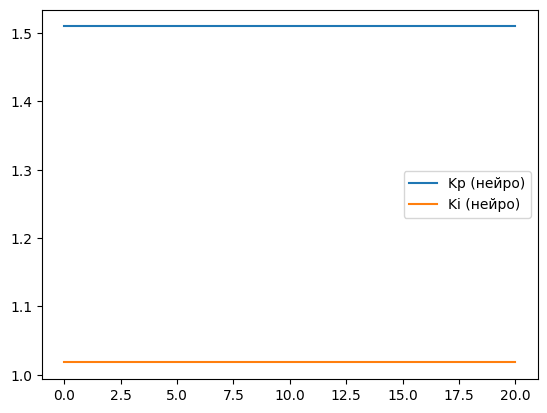

hybrid_pi.weight = 0.6

--- Оценка качества ---
Классика:   IAE=3.7846, RMSE=0.5672, Overshoot=1.30%, Settling Time=2.81 c
Гибрид:     IAE=3.4136, RMSE=0.5647, Overshoot=0.09%, Settling Time=2.77 c
Нейро-ПИ:   IAE=3.0366, RMSE=0.5154, Overshoot=0.72%, Settling Time=2.08 c

Первые 10 управляющих воздействий классика: [294.702 288.428 287.039 287.218 289.582 287.968 299.114 280.966 282.642
 285.348]
Первые 10 управляющих воздействий гибрид: []


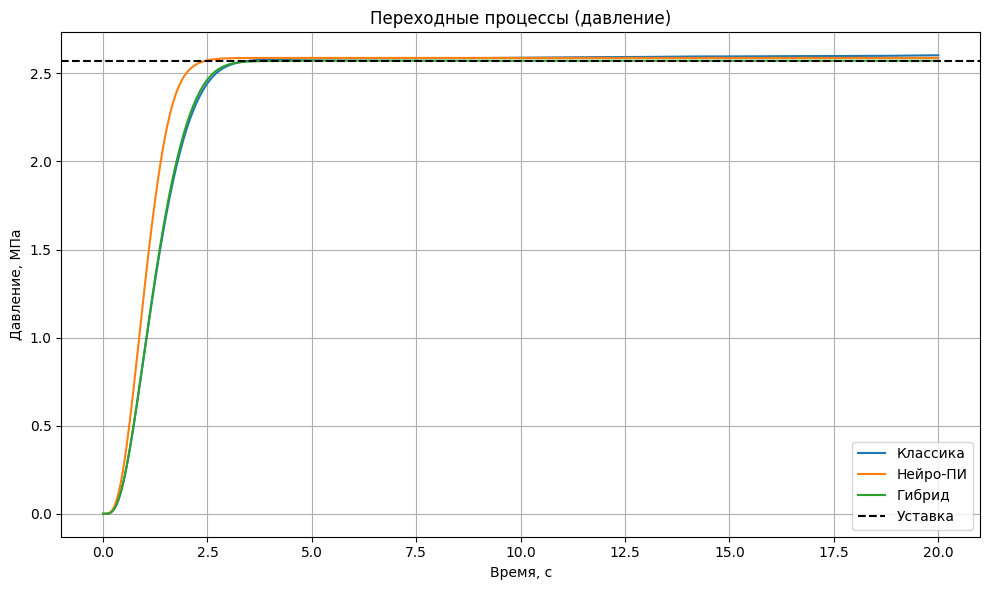

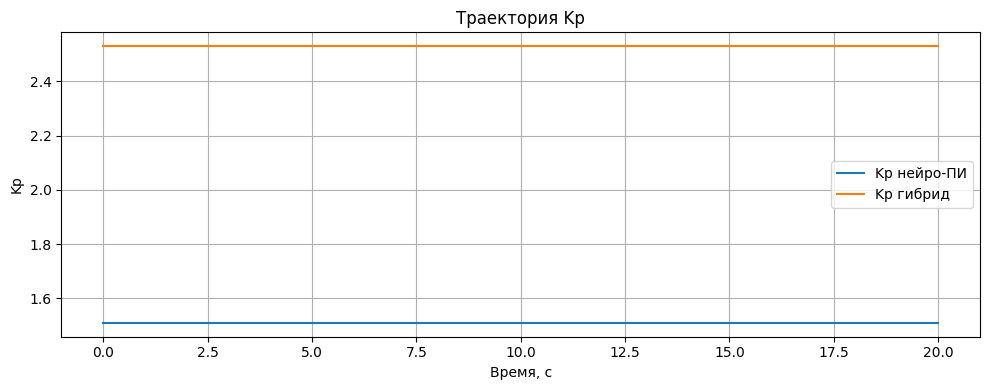

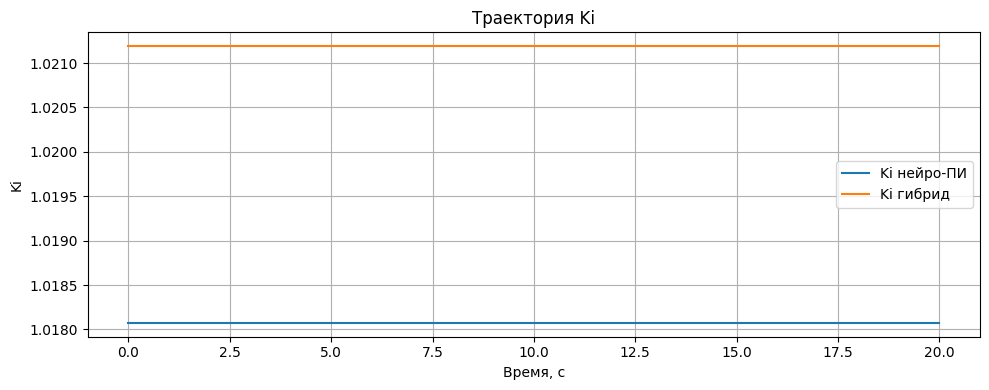

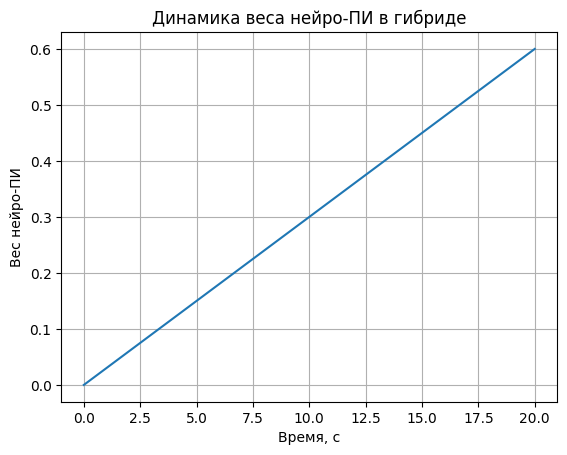

In [47]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Настройки шума и seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

NOISE_ENABLED = True
NOISE_LEVEL = 0.02

# Параметры объекта
manual_params = {
    'beta': 19.6783,
    'Tm': 0.2995,
    'Te': 0.0256,
    'Tfc': 0.1038,
    'kfc': 1.6613,
    'b': 0.7839,
    'h0': 0.7304,
    'x0': 1.0180,
    'Tp': 0.7938,
}
Kp_os_ratio = 0.2
Ki_os_ratio = 0.15

n_states = 5
T = np.linspace(0, 20, 500)
dt = T[1] - T[0]
X0 = np.zeros(n_states)
params_obj = [manual_params[k] for k in ['beta','Tm','Te','Tfc','kfc','b','h0','x0','Tp']]

def plant_update(t, x, u, params):
    beta, Tm, Te, Tfc, kfc, b, h0, x0, Tp = params
    x1, x2, x3, x4, x5 = x
    dx1_dt = (1.0 / (beta * Tm)) * (x2 - x1)
    dx2_dt = (beta / Te) * x3 - (beta / Te) * x1 - (1.0 / Te) * x2
    dx3_dt = (kfc / Tfc) * x4 - (1.0 / Tfc) * x3
    k_leak = 5.0
    dx5_dt = ((b / Tp) + ((2.0 * h0 * x0) / Tp)) * x1 - (1.0 / Tp) * x5 - k_leak * x5
    dx4_dt = u[0]
    return [dx1_dt, dx2_dt, dx3_dt, dx4_dt, dx5_dt]

# Генерация шума и уставки
setpoint = np.random.uniform(71, 581)
setpoint_mpa = setpoint * 0.00980665
print(f"Случайная уставка: {setpoint:.2f} м ({setpoint_mpa:.3f} МПа)")

if NOISE_ENABLED:
    noise_array = NOISE_LEVEL * setpoint * np.random.randn(len(T))
else:
    noise_array = np.zeros(len(T))

def get_noise_for_t_idx(idx, noise_array):
    if idx >= len(noise_array):
        idx = len(noise_array) - 1
    return noise_array[idx]

class PIControllerWithOS:
    def __init__(self, Kp, Ki, dt, Kp_os, Ki_os, config=None,
                 u_min=0, u_max=3000, integral_min=-20, integral_max=20):
        self.Kp = Kp
        self.Ki = Ki
        self.Kp_os = Kp_os
        self.Ki_os = Ki_os
        self.dt = dt
        self.integral = 0.0
        self.u_min = u_min
        self.u_max = u_max
        self.integral_min = integral_min
        self.integral_max = integral_max
        self.x1_prev = None
        self.config = config

    def reset(self):
        self.integral = 0.0
        self.x1_prev = None

    def __call__(self, setpoint, measurement, x1):
        if self.config is not None and self.config.get('noise_enabled', False):
            noise = self.config['noise_level'] * setpoint * np.random.randn()
            measurement += noise
        error = setpoint - measurement
        self.integral += error * self.dt
        self.integral = np.clip(self.integral, self.integral_min, self.integral_max)
        if self.x1_prev is None:
            dx1_dt_num = 0.0
        else:
            dx1_dt_num = (x1 - self.x1_prev) / self.dt
        self.x1_prev = x1
        u = (self.Kp * error + self.Ki * self.integral
             - self.Kp_os * dx1_dt_num
             - self.Ki_os * x1)
        return np.clip(u, self.u_min, self.u_max)

# Подгрузка нейросети
class ParamNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, dropout_p=0.25):
        super(ParamNet, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_p),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_p),
            torch.nn.Linear(32, output_dim),
            nn.Softplus()
        )
    def forward(self, x):
        return self.net(x)

ckpt = torch.load('neuro_param_selector.pt', map_location='cpu')
X_min = ckpt['X_min']
X_max = ckpt['X_max']
y_mean = ckpt['y_mean']
y_std = ckpt['y_std']
input_dim = len(X_min)
output_dim = len(y_mean)
neuro_model = ParamNet(input_dim, output_dim)
neuro_model.load_state_dict(ckpt['model_state_dict'])
neuro_model.eval()

class NeuroPIController:
    def __init__(self, neuro_model, X_min, X_max, y_mean, y_std, dt):
        self.neuro_model = neuro_model
        self.X_min = X_min
        self.X_max = X_max
        self.y_mean = y_mean
        self.y_std = y_std
        self.dt = dt
        self.integral_neuro = 0.0
        self.integral_min = -20
        self.integral_max = 20

    def reset(self):
        self.integral_neuro = 0.0

    def get_neuro_params(self, setpoint, iae, rmse, overshoot):
        features = np.array([setpoint, 0.0, iae, rmse, overshoot, 1.0], dtype=np.float32)
        features_norm = (features - self.X_min) / (self.X_max - self.X_min + 1e-8)
        features_tensor = torch.tensor(features_norm, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            neuro_params_norm = self.neuro_model(features_tensor).numpy()[0]
        neuro_params = neuro_params_norm * self.y_std + self.y_mean
        Kp_n = np.clip(neuro_params[0], 0.5, 3.0)
        Ki_n = np.clip(neuro_params[1], 0.05, 1.5)
        return Kp_n, Ki_n, features

class HybridPIController:
    def __init__(self, neuro_model, X_min, X_max, y_mean, y_std, dt, weight=0.4):
        self.neuro_model = neuro_model
        self.X_min = X_min
        self.X_max = X_max
        self.y_mean = y_mean
        self.y_std = y_std
        self.dt = dt
        self.weight = weight
        self.integral_neuro = 0.0
        self.integral_min = -20
        self.integral_max = 20

    def reset(self):
        self.integral_neuro = 0.0

    def get_neuro_params(self, setpoint, iae, rmse, overshoot):
        features = np.array([setpoint, 0.0, iae, rmse, overshoot, 1.0], dtype=np.float32)
        features_norm = (features - self.X_min) / (self.X_max - self.X_min + 1e-8)
        features_tensor = torch.tensor(features_norm, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            neuro_params_norm = self.neuro_model(features_tensor).numpy()[0]
        neuro_params = neuro_params_norm * self.y_std + self.y_mean
        Kp_n = np.clip(neuro_params[0], 0.5, 3.0)
        Ki_n = np.clip(neuro_params[1], 0.05, 1.5)
        return Kp_n, Ki_n, features

# Классика
config = {'noise_enabled': NOISE_ENABLED, 'noise_level': NOISE_LEVEL}
pi_classic = PIControllerWithOS(1.0865, 0.1000, dt, 1.0865*Kp_os_ratio, 0.1000*Ki_os_ratio, config=config)
pi_classic.reset()

u_pi_log = []
def rhs_classic_with_noise(t, x, pi_classic, setpoint, params_obj, T, noise_array):
    measurement = x[4]
    noise = get_noise_for_t_idx(np.searchsorted(T, t), noise_array)
    measurement_noisy = measurement + noise
    x1 = x[0]
    u = pi_classic(setpoint, measurement_noisy, x1)
    # --- Логируем и печатаем первые 10 управляющих воздействий ---
    if len(u_pi_log) < 10:
        u_pi_log.append(u)
        # print(f"[classic] t={t:.3f} meas={measurement_noisy:.2f} set={setpoint:.2f} x1={x1:.2f} u={u:.2f}")
    dx = plant_update(t, x, [u], params_obj)
    return dx


sol_classic = solve_ivp(
    lambda t, x: rhs_classic_with_noise(t, x, pi_classic, setpoint, params_obj, T, noise_array),
    [T[0], T[-1]], X0.copy(), t_eval=T, method='RK45', rtol=1e-6, atol=1e-8
)
p_hist_classic = sol_classic.y[4]
pressure_hist_classic = p_hist_classic * 0.00980665

iae_buffer = []
rmse_buffer = []
overshoot_buffer = []
Kp_traj_neuro = []
Ki_traj_neuro = []

# Нейро
def rhs_neuro_with_noise(t, x, neuro_pi, setpoint, params_obj, T, noise_array):
    # Индекс текущего времени
    i = np.searchsorted(T, t)
    measurement = x[4] + get_noise_for_t_idx(i, noise_array)
    x1 = x[0]
    
    # --- Считаем IAE, RMSE, overshoot по буферам ---
    # Если буферы пусты, используем только текущее значение
    if len(iae_buffer) == 0:
        iae = 0.0
        rmse = 0.0
        overshoot = 0.0
        y_hist = [measurement]
    else:
        y_hist = [v for v in iae_buffer] + [measurement]
        iae = np.sum(np.abs(np.array(y_hist) - setpoint)) * dt
        rmse = np.sqrt(np.mean((np.array(y_hist) - setpoint) ** 2))
        overshoot = (np.max(y_hist) - setpoint) / setpoint * 100

    # Адаптация параметров
    Kp_n, Ki_n, _ = neuro_pi.get_neuro_params(setpoint, iae, rmse, overshoot)
    Kp_os_n = Kp_n * Kp_os_ratio
    Ki_os_n = Ki_n * Ki_os_ratio
    neuro_pi.Kp = Kp_n
    neuro_pi.Ki = Ki_n
    neuro_pi.Kp_os = Kp_os_n
    neuro_pi.Ki_os = Ki_os_n

    # Обновление интеграла и производной
    error = setpoint - measurement
    if not hasattr(neuro_pi, "integral"):
        neuro_pi.integral = 0.0
    neuro_pi.integral += error * dt
    neuro_pi.integral = np.clip(neuro_pi.integral, -20, 20)
    if not hasattr(neuro_pi, "x1_prev"):
        neuro_pi.x1_prev = x1
    dx1_dt_num = (x1 - neuro_pi.x1_prev) / dt
    neuro_pi.x1_prev = x1

    u_neuro = (neuro_pi.Kp * error + neuro_pi.Ki * neuro_pi.integral
               - neuro_pi.Kp_os * dx1_dt_num
               - neuro_pi.Ki_os * x1)
    u_neuro = np.clip(u_neuro, 0, 3000)
    dx = plant_update(t, x, [u_neuro], params_obj)

    # Добавление в буферы
    iae_buffer.append(measurement)
    rmse_buffer.append(measurement)
    overshoot_buffer.append(measurement)
    Kp_traj_neuro.append(Kp_n)
    Ki_traj_neuro.append(Ki_n)
    return dx

neuro_pi = NeuroPIController(neuro_model, X_min, X_max, y_mean, y_std, dt)
neuro_pi.reset()

iae_buffer.clear()
rmse_buffer.clear()
overshoot_buffer.clear()
Kp_traj_neuro.clear()
Ki_traj_neuro.clear()

sol_neuro = solve_ivp(
    lambda t, x: rhs_neuro_with_noise(t, x, neuro_pi, setpoint, params_obj, T, noise_array),
    [T[0], T[-1]], X0.copy(), t_eval=T, method='RK45', rtol=1e-6, atol=1e-8
)

# Сбор траекторий Kp, Ki для нейро-ПИ
Kp_traj_neuro = []
Ki_traj_neuro = []
for i, t in enumerate(T):
    # Здесь можно посчитать iae, rmse, overshoot по sol_neuro.y[4, :i+1]
    iae = np.sum(np.abs(sol_neuro.y[4, :i+1] - setpoint)) * dt
    rmse = np.sqrt(np.mean((sol_neuro.y[4, :i+1] - setpoint) ** 2))
    overshoot = (np.max(sol_neuro.y[4, :i+1]) - setpoint) / setpoint * 100
    Kp_n, Ki_n, _ = neuro_pi.get_neuro_params(setpoint, iae, rmse, overshoot)
    Kp_traj_neuro.append(Kp_n)
    Ki_traj_neuro.append(Ki_n)
    
p_hist_neuro = sol_neuro.y[4]
pressure_hist_neuro = p_hist_neuro * 0.00980665

plt.plot(T, Kp_traj_neuro, label='Kp (нейро)')
plt.plot(T, Ki_traj_neuro, label='Ki (нейро)')
plt.legend()
plt.show()

def get_dynamic_weight(t, T_total, w_start=0.0, w_end=weight_neuro):
    return w_start + (w_end - w_start) * min(t / T_total, 1.0)

if NOISE_ENABLED:
    if NOISE_LEVEL >= 0.05:
        weight_neuro = 1.0
    elif NOISE_LEVEL > 0.01:
        weight_neuro = 0.6
    else:
        weight_neuro = 0.5
else:
    weight_neuro = 0.5
    
hybrid_pi = HybridPIController(neuro_model, X_min, X_max, y_mean, y_std, dt, weight=weight_neuro)
hybrid_pi.reset()

pi_classic_hybrid = PIControllerWithOS(1.0865, 0.1000, dt, 1.0865*Kp_os_ratio, 0.1000*Ki_os_ratio, config=config)
pi_classic_hybrid.reset()
pi_neuro_hybrid = PIControllerWithOS(0.1, 0.05, dt, 0.0, 0.0)
pi_neuro_hybrid.reset()

u_h_log = []
def rhs_hybrid_with_noise_param_mix(t, x, hybrid_pi, setpoint, params_obj, T, noise_array):
    i = np.searchsorted(T, t)
    measurement = x[4] + get_noise_for_t_idx(i, noise_array)
    x1 = x[0]

    # Получаем параметры классики
    Kp_classic = 1.0865
    Ki_classic = 0.1000
    Kp_os_classic = Kp_classic * Kp_os_ratio
    Ki_os_classic = Ki_classic * Ki_os_ratio

    # Получаем параметры нейро-ПИ
    iae = 0.0
    rmse = 0.0
    overshoot = 0.0
    Kp_neuro, Ki_neuro, _ = hybrid_pi.get_neuro_params(setpoint, iae, rmse, overshoot)
    Kp_os_neuro = Kp_neuro * Kp_os_ratio
    Ki_os_neuro = Ki_neuro * Ki_os_ratio

    # Динамический вес
    T_total = T[-1]
    w = get_dynamic_weight(t, T_total, w_start=0.0, w_end=weight_neuro)

    Kp_h = (1 - w) * Kp_classic + w * Kp_neuro
    Ki_h = (1 - w) * Ki_classic + w * Ki_neuro
    Kp_os_h = (1 - w) * Kp_os_classic + w * Kp_os_neuro
    Ki_os_h = (1 - w) * Ki_os_classic + w * Ki_os_neuro

    if not hasattr(rhs_hybrid_with_noise_param_mix, "pi_hybrid"):
        rhs_hybrid_with_noise_param_mix.pi_hybrid = PIControllerWithOS(
            Kp_h, Ki_h, dt, Kp_os_h, Ki_os_h)
        rhs_hybrid_with_noise_param_mix.pi_hybrid.reset()
    pi_hybrid = rhs_hybrid_with_noise_param_mix.pi_hybrid

    pi_hybrid.Kp = Kp_h
    pi_hybrid.Ki = Ki_h
    pi_hybrid.Kp_os = Kp_os_h
    pi_hybrid.Ki_os = Ki_os_h

    u_h = pi_hybrid(setpoint, measurement, x1)
    u_h = np.clip(u_h, 0, 3000)

    dx = plant_update(t, x, [u_h], params_obj)
    return dx

print("hybrid_pi.weight =", hybrid_pi.weight)

if hasattr(rhs_hybrid_with_noise_param_mix, "pi_hybrid"):
    rhs_hybrid_with_noise_param_mix.pi_hybrid.reset()
    
sol_hybrid = solve_ivp(
    lambda t, x: rhs_hybrid_with_noise_param_mix(t, x, hybrid_pi, setpoint, params_obj, T, noise_array),
    [T[0], T[-1]], X0.copy(), t_eval=T, method='RK45', rtol=1e-6, atol=1e-8
)
# Сбор траекторий Kp, Ki для гибрида
Kp_traj_hybrid = []
Ki_traj_hybrid = []
for i, t in enumerate(T):
    iae = 0.0
    rmse = 0.0
    overshoot = 0.0
    Kp_n, Ki_n, _ = hybrid_pi.get_neuro_params(setpoint, iae, rmse, overshoot)
    Kp_traj_hybrid.append(Kp_n)
    Ki_traj_hybrid.append(Ki_n)
    
p_hist_hybrid = sol_hybrid.y[4]
pressure_hist_hybrid = p_hist_hybrid * 0.00980665

def calc_metrics(pressure_hist, setpoint, T):
    iae = np.sum(np.abs(pressure_hist - setpoint)) * dt
    rmse = np.sqrt(np.mean((pressure_hist - setpoint) ** 2))
    overshoot = (np.max(pressure_hist) - setpoint) / setpoint * 100
    tolerance = 0.02 * setpoint
    settled_indices = np.where(np.abs(pressure_hist - setpoint) <= tolerance)[0]
    settling_time = T[settled_indices[0]] if len(settled_indices) > 0 else T[-1]
    return iae, rmse, overshoot, settling_time

pressure_setpoint = setpoint * 0.00980665
metrics_classic = calc_metrics(pressure_hist_classic, pressure_setpoint, T)
metrics_hybrid = calc_metrics(pressure_hist_hybrid, pressure_setpoint, T)
metrics_neuro = calc_metrics(pressure_hist_neuro, pressure_setpoint, T)

print("\n--- Оценка качества ---")
print(f"Классика:   IAE={metrics_classic[0]:.4f}, RMSE={metrics_classic[1]:.4f}, Overshoot={metrics_classic[2]:.2f}%, Settling Time={metrics_classic[3]:.2f} c")
print(f"Гибрид:     IAE={metrics_hybrid[0]:.4f}, RMSE={metrics_hybrid[1]:.4f}, Overshoot={metrics_hybrid[2]:.2f}%, Settling Time={metrics_hybrid[3]:.2f} c")
print(f"Нейро-ПИ:   IAE={metrics_neuro[0]:.4f}, RMSE={metrics_neuro[1]:.4f}, Overshoot={metrics_neuro[2]:.2f}%, Settling Time={metrics_neuro[3]:.2f} c")

print("\nПервые 10 управляющих воздействий классика:", np.round(u_pi_log, 3))
print("Первые 10 управляющих воздействий гибрид:", np.round(u_h_log, 3))

# График давления
plt.figure(figsize=(10, 6))
plt.plot(T, pressure_hist_classic, label='Классика')
plt.plot(T, pressure_hist_neuro, label='Нейро-ПИ')
plt.plot(T, pressure_hist_hybrid, label='Гибрид')
plt.axhline(pressure_setpoint, color='k', linestyle='--', label='Уставка')
plt.xlabel('Время, с')
plt.ylabel('Давление, МПа')
plt.title('Переходные процессы (давление)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# График Kp
plt.figure(figsize=(10, 4))
plt.plot(T, Kp_traj_neuro, label='Kp нейро-ПИ')
plt.plot(T, Kp_traj_hybrid, label='Kp гибрид')
plt.xlabel('Время, с')
plt.ylabel('Kp')
plt.title('Траектория Kp')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# График Ki
plt.figure(figsize=(10, 4))
plt.plot(T, Ki_traj_neuro, label='Ki нейро-ПИ')
plt.plot(T, Ki_traj_hybrid, label='Ki гибрид')
plt.xlabel('Время, с')
plt.ylabel('Ki')
plt.title('Траектория Ki')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(T, [get_dynamic_weight(t, T[-1], w_start=0.0, w_end=weight_neuro) for t in T])
plt.xlabel('Время, c')
plt.ylabel('Вес нейро-ПИ')
plt.title('Динамика веса нейро-ПИ в гибриде')
plt.grid()
plt.show()